# Prior and Posterior Predictive Checking in Bayesian Estimation

**Authors**: original R Tutorial created by Duco Veen and Sara van Erp; Python translation by Florian Metwaly.

Through this tutorial, learners will gain a practical understanding of conducting prior and posterior predictive checks in Bayesian estimation using `bambi`. We will include clear code examples, explanations, and visualizations at every step to ensure a comprehensive understanding of the process. We start out with simulated data examples and include a case study in Section 'Case Study: Applying Posterior Predictive Checks on infants’ speech discrimination data'.

**Learning Goals**

1. Understand the concepts of prior and posterior predictive checking in Bayesian estimation.
2. Learn how to do prior and posterior predictive checking, using the `bambi` and `arviz` packages.

## A Beginner's Guide to Predictive Checking

Welcome to the exciting world of predictive checking! This concept forms a core part of the Bayesian workflow and is a handy technique for validating and refining statistical models. Think of it like a quality check for your models. It takes advantage of the fact that Bayesian models can simulate data (they are generative models). We use this power to create what our model and its associated priors suggest could be possible data outcomes. It's like getting a sneak peek at what your model predicts even before you start the main analysis.

Now, predictive checking comes in two flavours: prior predictive checking and posterior predictive checking.

Prior predictive checking is like a dress rehearsal before the main event. It's all about simulating data based on the prior predictive distribution. And what decides this distribution? It's purely down to the model's prior distributions and the model's specifications, i.e., the parameters you've chosen for your model. It's like a behind-the-scenes pass that lets you see the potential outcomes of your prior choices and whether they make sense or have too much sway. Have you ever wondered if your chosen hyperparameters are spot on, or too narrow or too broad? Well, this is where prior predictive checks shine. They help you spot any issues that could unduly influence the final outcome. It also helps you to spot when you've mixed up specification, for instance, specifying a variances instead of a precision (yes this has happened to us).

On the other hand, posterior predictive checks are like the grand finale. They let us evaluate how well the model fits the observed data, and they consider both the data and the priors. So, it's like a comprehensive health check for your model. If the model generates data that looks a lot like our observed data, the model is specified well and healthy. If the model generates data that look very different, we might need a check-up.

These checks are like superpowers. They enable us to understand our model better, ensure it's working as expected, and decide on any tweaks if needed. So buckle up and let's dive deeper into the fascinating realm of predictive checking!


## Loading packages

First things first. We need some packages.

If you are using Google Colab, remove the # from the following line and run the chunk to install the `bambi` library:

In [2]:
!pip install bambi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 3.1 MB/s eta 0:00:00


In [3]:
import bambi as bmb # BAyesian Model-Building Interface in Python
import arviz as az # Exploratory analysis of Bayesian models
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

SEED = 1337

## Prior Predictive Checking

Let's imagine that the Dutch news reports an increase in bike thefts and we want to investigate the relation between bike thefts and the increase in temperature. Let's start by generating the simulated data. We simulate the number of bike thefts in a small village on a hundred random days. Please note, we are simplyfing the model, not taking any dependency between days into account and we act as if seasonal changes in weather can happen overnight.

In [4]:
np.random.seed(SEED)

# Generate simulated data
n = 100
temperature = np.random.uniform(0, 30, n)  # Random temperatures between 0 and 30
intercept = 10
slope = 0.5
noise_sd = 3

# Generate bike thefts and round to whole numbers
bike_thefts = np.round(intercept + slope * temperature + np.random.normal(0, noise_sd, n), 0)

# Create DataFrame
data = pd.DataFrame({
    'temperature': temperature,
    'bike_thefts': bike_thefts
})

Let's take a quick look at our data to get a feel for what they look like.

Firstly, we can get summary statistics for our data.

In [5]:
data.describe()

temperature  bike_thefts
count   100.000000   100.000000
mean     15.245667    17.800000
std       8.386639     4.748205
min       0.087031     7.000000
25%       8.248724    15.000000
50%      14.773197    18.000000
75%      21.959136    21.000000
max      29.921674    28.000000

Next, let's take a look at the first few rows of the data.

In [6]:
data.head()

temperature  bike_thefts
0     7.860740         16.0
1     4.760519         10.0
2     8.343796         15.0
3    13.779507         19.0
4     9.630016         18.0

Finally, let's visualize our data. We'll create a scatterplot to see if there's a visible correlation between the temperature and the number of bike thefts.

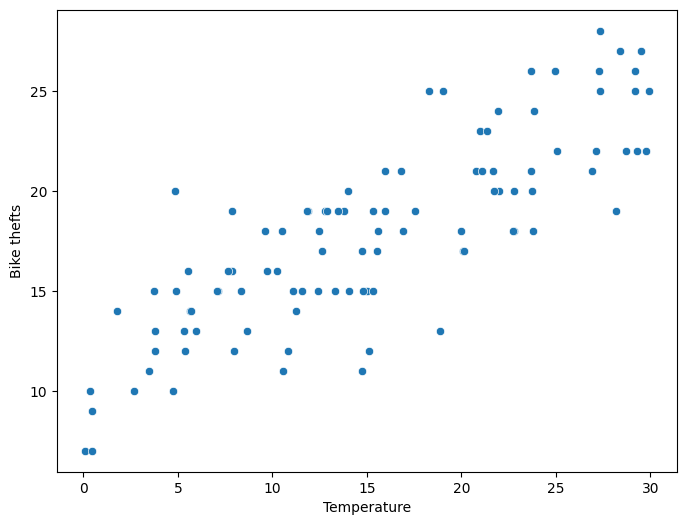

In [7]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x="temperature", y="bike_thefts")

plt.xlabel("Temperature")
plt.ylabel("Bike thefts")

plt.show()

Now that we have our simulated data, let's define our model and priors in `bambi` and fit the data. Use a normal prior centered around 10 with a standard deviation of 5 for the intercept and a standard normal prior for the regression coefficients. See if you can do this yourself before looking at the solutions.

*Hint:* check out the bambi [website](https://bambinos.github.io/bambi/) on how to specify the priors and call the model. How do you get only samples from the prior?

In [8]:
# Exercise 1: Please try writing and running the code yourself before checking the correct solution below.

<details><summary>Click here for the solution</summary>

```python
# Define priors
prior_intercept = bmb.Prior("Normal", mu=10, sigma=5)
prior_temp = bmb.Prior("Normal", mu=0, sigma=1)

priors = {
    "Intercept": prior_intercept,
    "temperature": prior_temp
}

# Define the model
model = bmb.Model("bike_thefts ~ temperature",
                  data=data,
                  priors=priors,
                  family="gaussian",
                  center_predictors=False)



# Build the model, to be able to sample from the prior, but no need to run the complete model
model.build()

```

</details>

Great, once we've fit our model, we can use the `az.plot_ppc` function of the `arviz` library. To do so, we first have to sample from the prior distribution using the `model.prior_predictive()` function.

In [9]:
idata_prior = model.prior_predictive(draws=500, random_seed=SEED)

The most basic thing we can look at is to see what possible distributions of the data are simulated.

<Axes: xlabel='bike_thefts'>

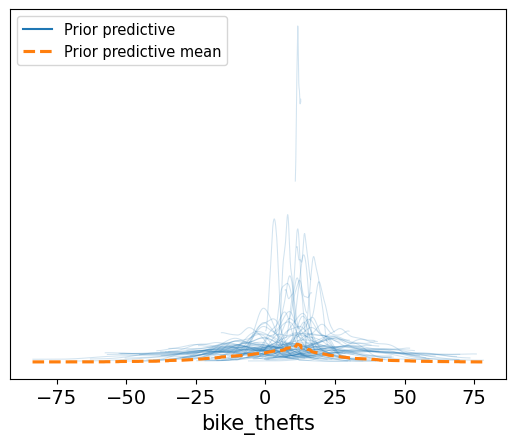

In [10]:
az.plot_ppc(idata_prior, group="prior", num_pp_samples=100, random_seed=SEED)

Note that we didn't specify any kind. If we don't specify the kind `kde` is used, meaning that we get kernel density estimates of the possible data distributions given these priors and this model.

<Axes: xlabel='bike_thefts'>

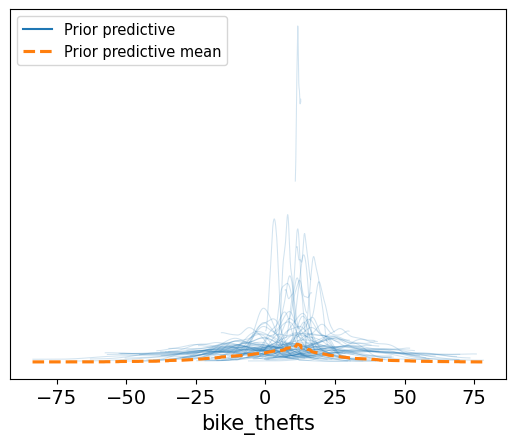

In [11]:
az.plot_ppc(idata_prior,group="prior", kind="kde", num_pp_samples=100, random_seed=SEED)

We see that our priors indicate that distributions of possible data of stolen bikes include negative numbers. That would not be something realistic. We could adjust our model to not allow negative values. This could be done by adjusting the priors so that these values do not occur. We could also restrict values to be positive by means of truncation. In `bambi`, truncation of the response variable is [not implemented yet](https://discourse.pymc.io/t/bambi-truncated-response-variables/12441). But, truncated distributions are harder to work with and interpret, [sometimes leading to computational issues](https://discourse.mc-stan.org/t/nas-produced-in-posterior-predict-for-truncated-model/26986). So for now, we will not truncate our model, but look a bit further to see if this is a true problem. In any case, we want our models to cover the range of values that are plausible, and many predicted distributions are falling between 0 and 50 bikes stolen, which given our small village example is plausible. However, the predicted distributions seem narrow, perhaps we can look at summary statistics of the predicted distributions to get more information.

To do so, we first have to calculate the mean and standard deviation of each prior predictive draw.

In [12]:
# Extract and stack the prior predictive samples
y_prior = idata_prior["prior_predictive"].stack(sample=("chain", "draw"))

# Compute mean for each sample
means_per_draw = y_prior.mean(dim="__obs__")

# Compute std for each sample
sds_per_draw = y_prior.std(dim="__obs__")

Now we can plot them

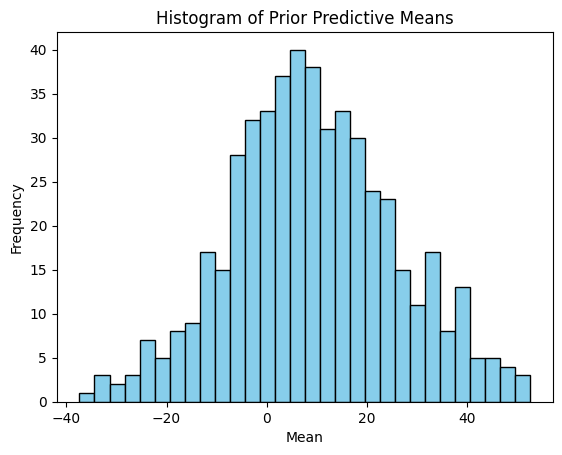

In [13]:
plt.hist(means_per_draw["bike_thefts"], bins=30, color="skyblue", edgecolor="black")
plt.title("Histogram of Prior Predictive Means")
plt.xlabel("Mean")
plt.ylabel("Frequency")
plt.show()

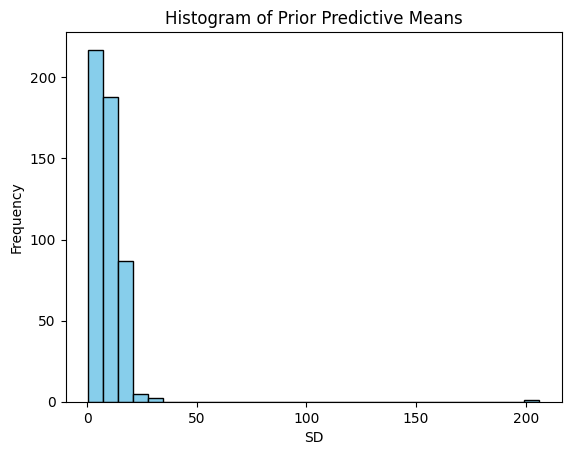

In [14]:
plt.hist(sds_per_draw["bike_thefts"], bins=30, color="skyblue", edgecolor="black")
plt.title("Histogram of Prior Predictive Means")
plt.xlabel("SD")
plt.ylabel("Frequency")
plt.show()

And we can plot the means and standard deviations combined:

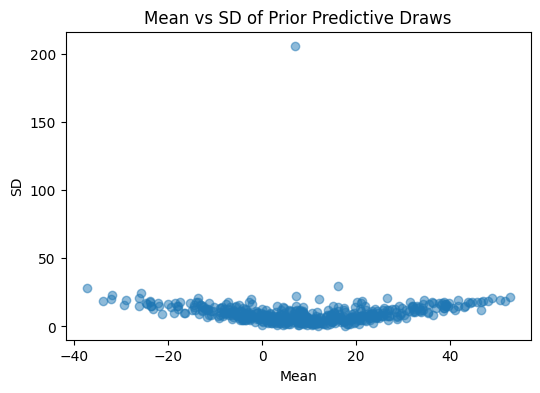

In [15]:
plt.figure(figsize=(6, 4))
plt.scatter(means_per_draw["bike_thefts"], sds_per_draw["bike_thefts"], alpha=0.5)
plt.title("Mean vs SD of Prior Predictive Draws")
plt.xlabel("Mean")
plt.ylabel("SD")
plt.show()


We see that most models produce positive means with small standard deviations. Perhaps we think these values are plausible, especially since they produce a broad range of possibilities. Perhaps we think we need to adjust our model a bit. Let's say that we would like to imply a bit more bike thefts on average and more uncertainty. We could adjust our priors to incorporate this. We also specify a broader prior on the residuals. To see which prior was used originally by default we can inspect the model object:

In [16]:
model

       Formula: bike_thefts ~ temperature
        Family: gaussian
          Link: mu = identity
  Observations: 100
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 10.0, sigma: 5.0)
            temperature ~ Normal(mu: 0.0, sigma: 1.0)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 4.7244)

Try to specify the priors in such a way that you imply a bit more bike thefts on average and more uncertainty. Specify and fit this revised model.

In [17]:
# Exercise 2: Please try writing and running the code yourself before checking the correct solution below.

<details><summary>Click here for the solution</summary>

```python
# Define priors
prior_intercept = bmb.Prior("Normal", mu=15, sigma=7)
prior_slope = bmb.Prior("Normal", mu=0, sigma=2)
prior_sigma = bmb.Prior("HalfStudentT", nu=3, sigma=10)

priors2 = {
    "Intercept": prior_intercept,
    "temperature": prior_slope,
    "sigma": prior_sigma
}

# Define the model
model2 = bmb.Model("bike_thefts ~ temperature",
                  data=data,
                  priors=priors2,
                  family="gaussian",
                  center_predictors=False)

# Build the model, to be able to sample from the prior, but no need to run the complete model
model2.build()

```

</details>

Now let's check what changed. First, we have to sample from the prior again.

In [18]:
idata_prior2 = model2.prior_predictive(draws=500, random_seed=SEED)

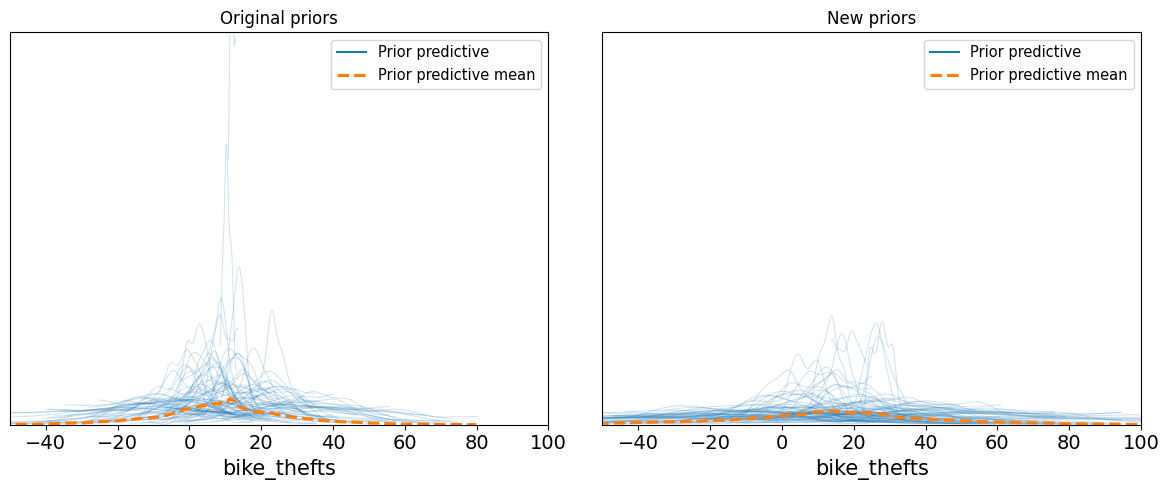

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot prior predictive checks for first prior
az.plot_ppc(idata_prior, group="prior", kind="kde", num_pp_samples=100, ax=axes[0])
axes[0].set_title("Original priors")
axes[0].set_xlim(-50, 100)
axes[0].set_ylim(0, 0.5)

# Plot prior predictive checks for second prior
az.plot_ppc(idata_prior2, group="prior", kind="kde", num_pp_samples=100, ax=axes[1])
axes[1].set_title("New priors")
axes[1].set_xlim(-50, 100)
axes[1].set_ylim(0, 0.5)

plt.tight_layout()
plt.show()

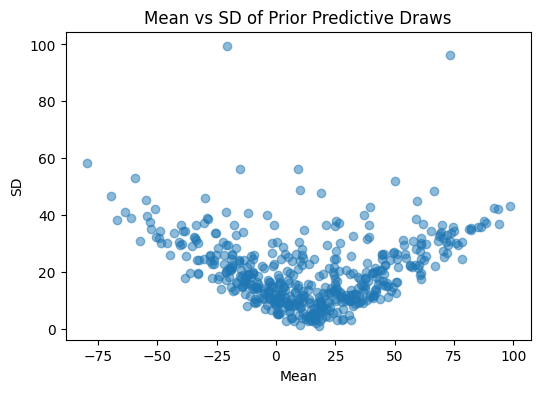

In [20]:
# Extract and stack the prior predictive samples
y_prior2 = idata_prior2["prior_predictive"].stack(sample=("chain", "draw"))

# Compute mean for each sample
means_per_draw2 = y_prior2.mean(dim="__obs__")

# Compute std for each sample
sds_per_draw2 = y_prior2.std(dim="__obs__")

plt.figure(figsize=(6, 4))
plt.scatter(means_per_draw2["bike_thefts"], sds_per_draw2["bike_thefts"], alpha=0.5)
plt.title("Mean vs SD of Prior Predictive Draws")
plt.xlabel("Mean")
plt.ylabel("SD")
plt.show()

We indeed see much more spread in the predicted summary statistics, indicating more uncertainty beforehand. The new priors indicate a bit higher expected means and more variance in the predicted data sets. This is what we wanted and now we are happy with our priors and we can fit our model with our "observed" (simulated) data.

## Posterior Predictive Checking

The first step before we can do posterior predictive checking is to obtain the posterior by fitting the model. Set a seed to make sure your results are reproducible.

In [56]:
# Exercise 3: Please try writing and running the code yourself before checking the correct solution below

Output()

<details><summary>Click here for the solution</summary>

```python
fit = model2.fit(seed=SEED)

```

</details>

Now let's look at the summary of the model.

In [57]:
az.summary(fit)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept    10.715  0.564   9.711   11.854      0.018    0.014    1014.0   
sigma         2.729  0.187   2.385    3.071      0.005    0.004    1401.0   
temperature   0.466  0.033   0.397    0.521      0.001    0.001     947.0   

             ess_tail  r_hat  
Intercept      1141.0    1.0  
sigma          1241.0    1.0  
temperature    1122.0    1.0

How well are we estimating? Remember that we simulated the data, so we know the true parameter values. These were `intercept = 10`, `slope = 0.5` and `noise_sd = 3`. The model finds these values back very accurately. Great! We could check the model fit and computation. For instance, get some chain plots. And did you know that you could change the color schemes using `az.style.use()`? You can even set it such that the colors are adjusted to account for the common form of colorblindness and rely less on red-green contrast. These schemes are called "viridis" and there are more options. Let's see some options we could use.

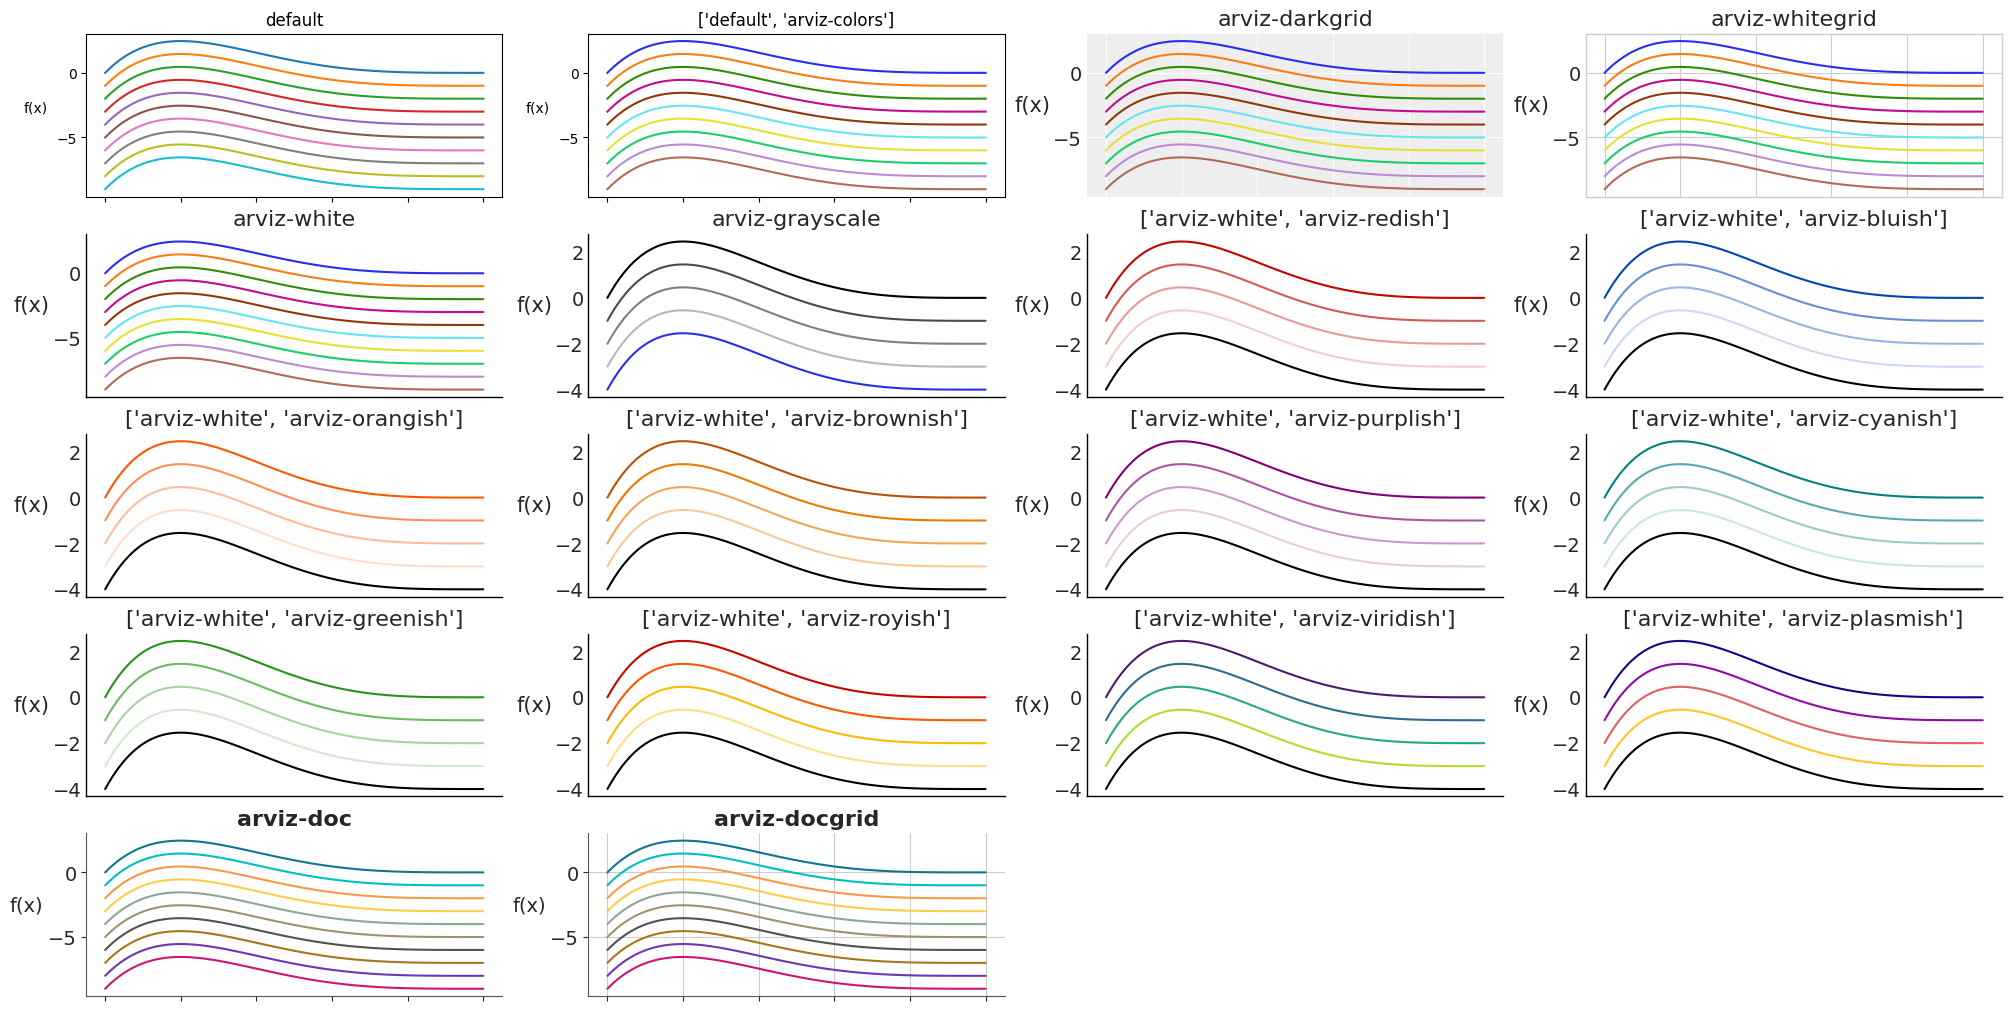

In [33]:
from scipy import stats

x = np.linspace(0, 1, 100)
dist = stats.beta(2, 5).pdf(x)

style_list = [
    "default",
    ["default", "arviz-colors"],
    "arviz-darkgrid",
    "arviz-whitegrid",
    "arviz-white",
    "arviz-grayscale",
    ["arviz-white", "arviz-redish"],
    ["arviz-white", "arviz-bluish"],
    ["arviz-white", "arviz-orangish"],
    ["arviz-white", "arviz-brownish"],
    ["arviz-white", "arviz-purplish"],
    ["arviz-white", "arviz-cyanish"],
    ["arviz-white", "arviz-greenish"],
    ["arviz-white", "arviz-royish"],
    ["arviz-white", "arviz-viridish"],
    ["arviz-white", "arviz-plasmish"],
    "arviz-doc",
    "arviz-docgrid",
]

fig = plt.figure(figsize=(20, 10), layout="constrained")
for idx, style in enumerate(style_list):
    with az.style.context(style, after_reset=True):
        ax = fig.add_subplot(5, 4, idx + 1, label=idx)
        colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
        for i in range(len(colors)):
            ax.plot(x, dist - i, f"C{i}", label=f"C{i}")
        ax.set_title(style)
        ax.set_ylabel("f(x)", rotation=0, labelpad=15)
        ax.set_xticklabels([])

plt.show()

To set the style to the viridis colour map, use the following command:

In [34]:
az.style.use("arviz-viridish")

After that quick sidestep, let's plot our posteriors.

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'temperature'}>,
        <Axes: title={'center': 'temperature'}>]], dtype=object)

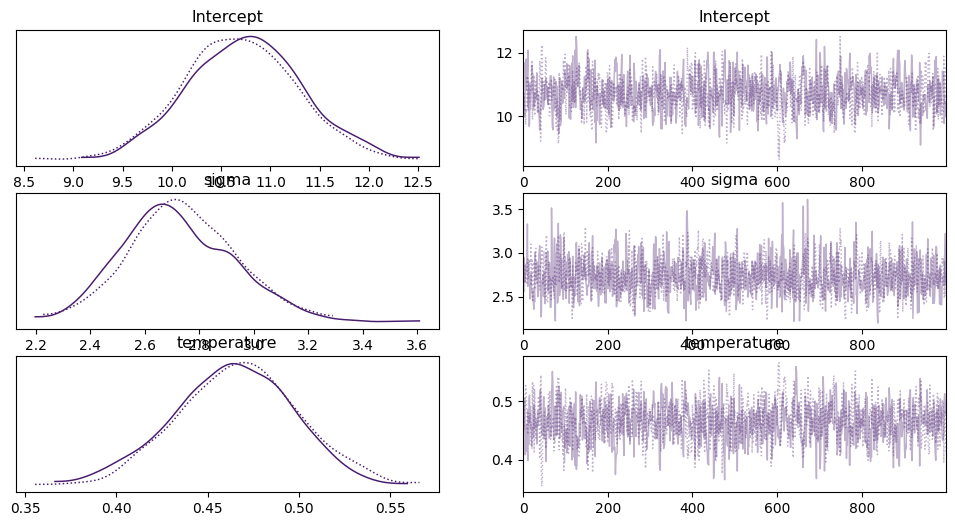

In [35]:
az.plot_trace(fit)

array([<Axes: title={'center': 'Intercept'}>,
       <Axes: title={'center': 'sigma'}>,
       <Axes: title={'center': 'temperature'}>], dtype=object)

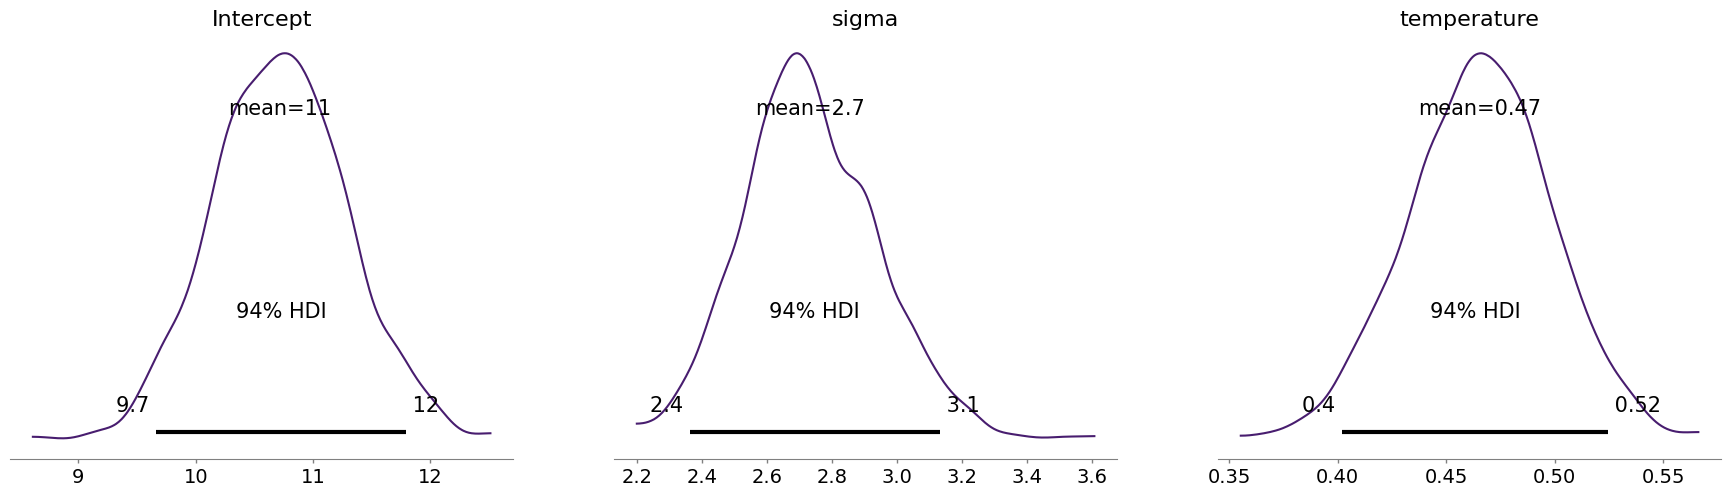

In [36]:
az.plot_posterior(fit)


Note that we use the argument `combined = True` to combine multiple chains into a single chain. The default is to show the plot per MCMC chain separately.

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

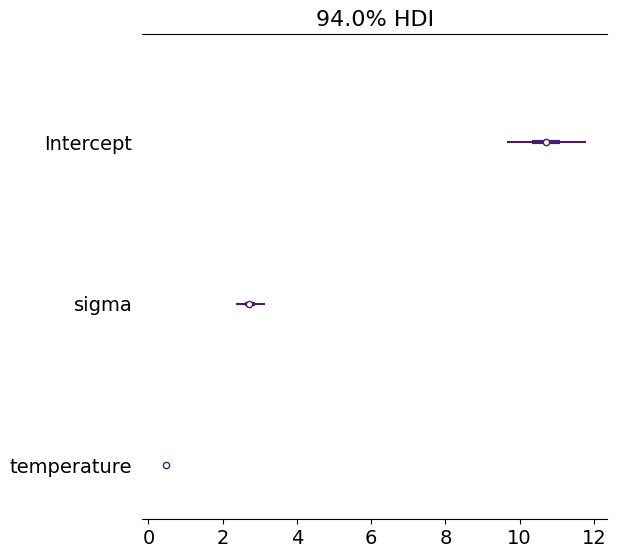

In [38]:
az.plot_forest(fit, combined = True)

array([<Axes: title={'center': 'Intercept'}>,
       <Axes: title={'center': 'sigma'}>,
       <Axes: title={'center': 'temperature'}>], dtype=object)

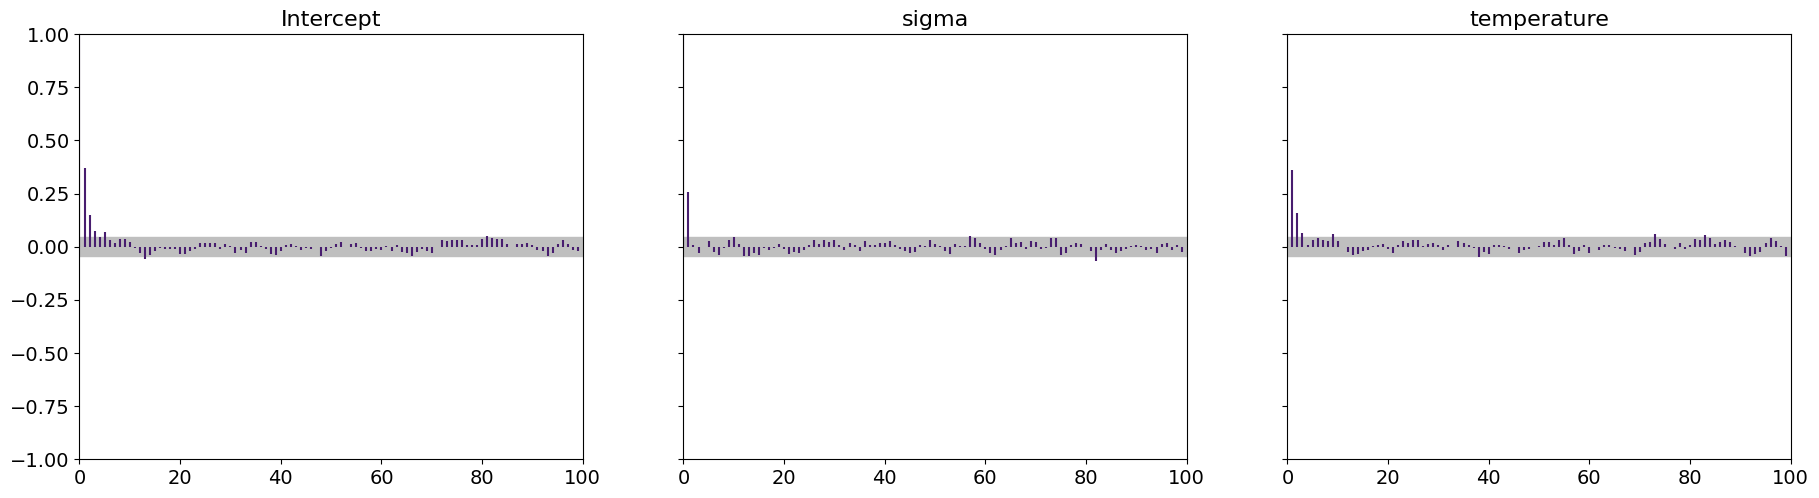

In [39]:
az.plot_autocorr(fit, combined = True)

Convergence seems well, the densities are nice and smooth and there is little autocorrelation. But we already had some indications for this. Did you notice that in the output for the fit object we already got information on `Rhat` and the effective sample size for each parameter? These indicated that everything was going well.

Now let's look at the posterior predictive checks. We can use the `pp_check` function again. This time however, we do posterior predictive checks. We already used our data, so it might be nice to also compare what the model looks like compared to our observed data. For that, we use `az.plot_ppc`.

In [40]:
model.predict(fit, kind="response")

<Axes: xlabel='bike_thefts'>

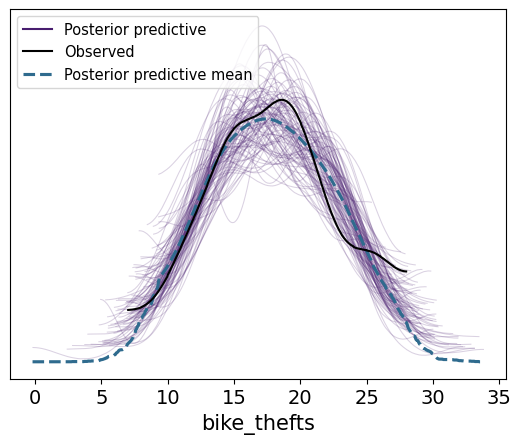

In [41]:
az.plot_ppc(fit, num_pp_samples=100)

We can see that the data sets that are predicted by the model are very similar to our observed data set. That's a good sign. Let's do some additional investigations.

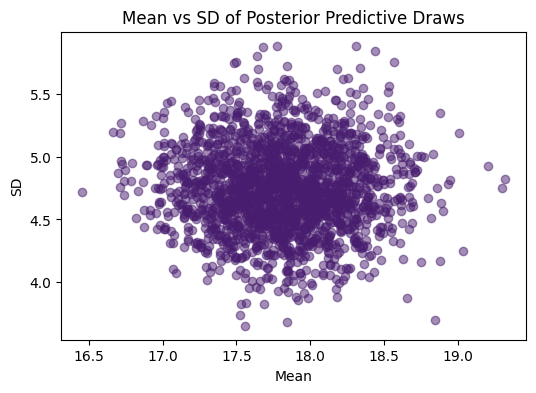

In [42]:
# Extract and stack the prior predictive samples
y_post = fit["posterior_predictive"].stack(sample=("chain", "draw"))

# Compute mean for each sample
means_per_draw_post = y_post.mean(dim="__obs__")

# Compute std for each sample
sds_per_draw_post = y_post.std(dim="__obs__")

plt.figure(figsize=(6, 4))
plt.scatter(means_per_draw_post["bike_thefts"], sds_per_draw_post["bike_thefts"], alpha=0.5)
plt.title("Mean vs SD of Posterior Predictive Draws")
plt.xlabel("Mean")
plt.ylabel("SD")
plt.show()

Our observed data is also similar to the predicted data if you look at the mean and standard deviation of the generated data sets based on the posterior draws. This is great, but it's compared to the data we also used to fit the model with. How would we perform against new data? How about we simulate a bit more new data and see. We use a different seed and sample 50 new cases. We use the same data generating mechanism of course. In practice, unfortunately, it is not so easy to collect new data. A more realistic approach would therefore be to split our existing data in a training and test set and use the training set to fit the model and the test set to perform the posterior predictive checks on. This will come up in a later tutorial.

In [48]:
np.random.seed(951)

n_new = 50
temperature_new = np.random.uniform(0, 30, size=n_new)
intercept = 10
slope = 0.5
noise_sd = 3

bike_thefts_new = np.round(intercept + slope * temperature_new + np.random.normal(0, noise_sd, size=n_new))

data_new = pd.DataFrame({
    "temperature": temperature_new,
    "bike_thefts": bike_thefts_new
})


In [49]:
idata_pp_new = model2.predict(idata=fit, data=data_new, kind="response", inplace=False)

<Axes: xlabel='bike_thefts'>

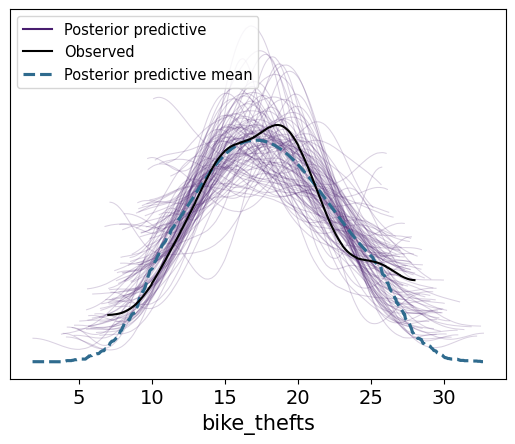

In [50]:
az.plot_ppc(idata_pp_new, kind="kde", num_pp_samples=100)

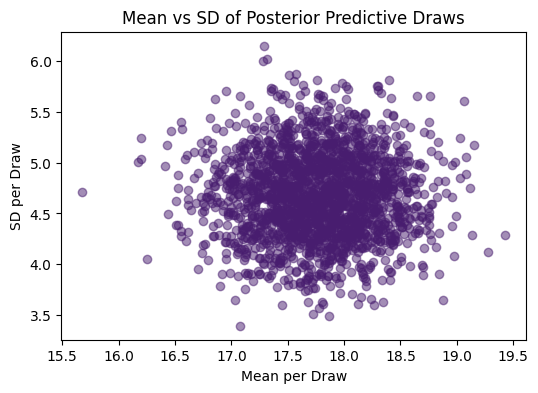

In [51]:
# Extract and stack the prior predictive samples
y_post2 = idata_pp_new["posterior_predictive"].stack(sample=("chain", "draw"))

# Compute mean for each sample
means_per_draw_post2 = y_post2.mean(dim="__obs__")

# Compute std for each sample
sds_per_draw_post2 = y_post2.std(dim="__obs__")

plt.figure(figsize=(6, 4))
plt.scatter(means_per_draw_post2["bike_thefts"], sds_per_draw_post2["bike_thefts"], alpha=0.5)
plt.title("Mean vs SD of Posterior Predictive Draws")
plt.xlabel("Mean per Draw")
plt.ylabel("SD per Draw")
plt.show()

Great, with new data we also do well!

## Did we learn?

Now did we learn more about the parameters? Our model did well to predict our existing data and new data. But did we decrease our uncertainty about the parameters in this model? We can provide some nice insights into this. We also sampled from the priors so we can easily visualize this.

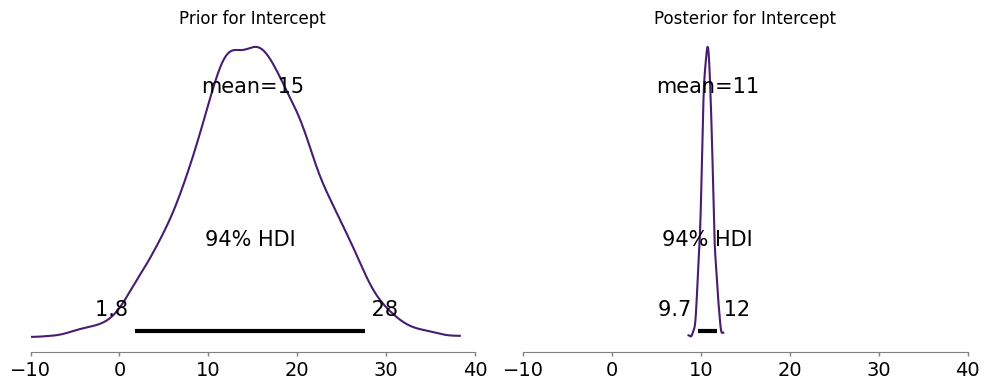

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

# Plot prior
model2.plot_priors(var_names=["Intercept"], ax=axes[0])
axes[0].set_title("Prior for Intercept")

# Plot posterior
az.plot_posterior(fit, var_names=["Intercept"], ax=axes[1])
axes[1].set_title("Posterior for Intercept")

# Set same x-limits
axes[0].set_xlim(-10, 40)
axes[1].set_xlim(-10, 40)

plt.tight_layout()
plt.show()


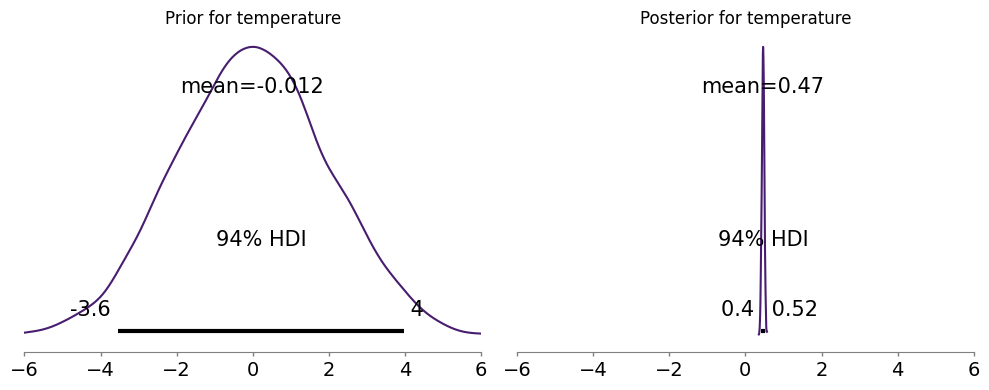

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

# Plot prior
model2.plot_priors(var_names=["temperature"], ax=axes[0])
axes[0].set_title("Prior for temperature")

# Plot posterior
az.plot_posterior(fit, var_names=["temperature"], ax=axes[1])
axes[1].set_title("Posterior for temperature")

# Set same x-limits
axes[0].set_xlim(-6, 6)
axes[1].set_xlim(-6, 6)

plt.tight_layout()
plt.show()


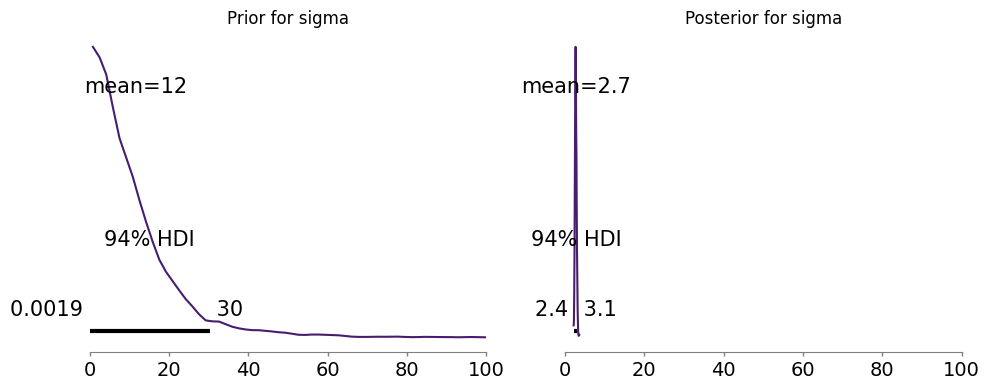

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

# Plot prior
model2.plot_priors(var_names=["sigma"], ax=axes[0])
axes[0].set_title("Prior for sigma")

# Plot posterior
az.plot_posterior(fit, var_names=["sigma"], ax=axes[1])
axes[1].set_title("Posterior for sigma")

# Set same x-limits
axes[0].set_xlim(0, 100)
axes[1].set_xlim(0, 100)

plt.tight_layout()
plt.show()


We could also express this in terms of posterior shrinkage using <a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1)
$$
s = 1 - \frac{\sigma^2_\text{posterior}}{\sigma^2_\text{prior}}.
$$

Since the posterior distribution combines the information in the prior with the information in the likelihood of the data, it will usually have less uncertainty so a smaller variance. If the data is highly informative compared to the prior, the posterior shrinkage will be close to 1. If the data provides little additional information, the posterior shrinkage will be close to 0.

To calculate this we can use the following code:

In [55]:
prior_sd_intercept = np.sqrt(5)
prior_sd_temperature = 1

# Get posterior summary
summary = az.summary(fit, var_names=["Intercept", "temperature"], round_to=4)

# Extract posterior SDs
posterior_sd_intercept = summary.loc["Intercept", "sd"]
posterior_sd_temperature = summary.loc["temperature", "sd"]

# Manually specify prior SDs based on your model
prior_sd_intercept = 5
prior_sd_temperature = 1

# Calculate shrinkage
intercept_shrinkage = 1 - (posterior_sd_intercept**2 / prior_sd_intercept**2)
temperature_shrinkage = 1 - (posterior_sd_temperature**2 / prior_sd_temperature**2)

# Print results
print(f"Intercept shrinkage: {intercept_shrinkage:.3f}")
print(f"Temperature shrinkage: {temperature_shrinkage:.3f}")

Intercept shrinkage: 0.987
Temperature shrinkage: 0.999


For both parameters we greatly reduced the uncertainty that we had. Awesome.

## Case Study: Applying Posterior Predictive Checks on infants' speech discrimination data

In this case study we will see how posterior predictive checks can help to decide if a model is useful. We will analyze part of a data set that investigates infants' speech discrimination performance<a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-2). In short, can infants make a distinction between sounds originating from the (parents') native language compared to sounds not from that language. For each infant there are 12 sequential trials for which the log of the fixation time is recorded. There are 2 different trial types (coded 0 for non-native and 1 for the native language contrast). We look at 12 infants.


The data is available in the `time_data.csv` file, but can also be recreated by running the following code.

In [58]:
data = pd.DataFrame({
    'X': np.arange(1, 145),
    'id': [
        1, 1, 1, 1, 1, 1, 1,
1 , 1 , 1 , 1 , 1 , 2 , 2 , 2 , 2 , 2 , 2 , 2 , 2 , 2 , 2 , 2 ,
2 , 3 , 3 , 3 , 3 , 3 , 3 , 3 , 3 , 3 , 3 , 3 , 3 , 4 , 4 , 4 ,
4 , 4 , 4 , 4 , 4 , 4 , 4 , 4 , 4 , 5 , 5 , 5 , 5 , 5 , 5 , 5 ,
5 , 5 , 5 , 5 , 5 , 6 , 6 , 6 , 6 , 6 , 6 , 6 , 6 , 6 , 6 , 6,
6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8,
8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9,
9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10,
10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
12
    ],
    'trialnr': [
        1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2,
3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5,
6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2,
3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5,
6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
    ],
    'trialtype': [
        1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0
    ],
    'loglt': [
        3.44839710345777, 3.53237213356788, 3.61573968861916,
    3.44138088491651, 3.5081255360832, 4.15812115033749, 3.65176244738011,
    4.2520759437998, 4.03277987919124, 4.20782279900151, 3.57818060962778,
    4.11417714024445, 3.52853106063541, 3.58489634413745, 3.39252108993193,
    3.58478337899651, 3.41077723337721, 3.878751520173, 3.73134697554595,
    3.56655533088305, 3.71466499286254, 3.61341894503457, 3.73703353133388,
    3.67951874369579, 4.09933527768596, 3.78333176288742, 4.00004342727686,
    3.92556990954338, 3.64483232882564, 3.38756777941719, 3.68565218411552,
    3.51851393987789, 4.17577265960154, 3.90260113066653, 3.89597473235906,
    4.06220580881971, 4.10744740952361, 4.24306286480481, 4.17163870853082,
    3.816042340922, 4.24659704910637, 3.69469292633148, 4.22980978295254,
    4.48023697181947, 3.83853427051187, 3.56631962152481, 3.7521253072979,
    4.08159931273294, 4.1814433955419, 3.46119828862249, 3.80861603542699,
    3.78247262416629, 3.71264970162721, 3.62065647981962, 3.66426580014768,
    3.64345267648619, 3.34222522936079, 3.28645646974698, 3.29600666931367,
    3.87174801899187, 3.53794495929149, 3.72558497227069, 3.81298016603948,
    4.1026394836913, 4.01127432890473, 4.15962734065867, 4.17851652373358,
    4.34629428204135, 4.02966780267532, 4.01770097122412, 4.23709111227397,
    4.03977092693158, 3.67200544502295, 3.77312792403333, 3.76767522402796,
    3.80726435527611, 3.75966784468963, 3.97206391600802, 4.27323283404305,
    3.9843022319799, 3.94235534970768, 3.73134697554595, 3.81070286094712,
    3.68502478510571, 4.05556944006099, 4.15878451772342, 3.58103894877217,
    3.98815747255675, 3.88326385958497, 3.85229696582693, 3.61225390609644,
    3.32325210017169, 3.3809344633307, 3.62479757896076, 3.45224657452044,
    3.38792346697344, 3.91301868374796, 4.02657411815033, 3.74826557266874,
    4.08145532782257, 3.76110053895814, 3.24674470972384, 3.80807586809131,
    3.59604700754544, 3.63718942214876, 3.82885315967664, 3.6728364541714,
    3.8318697742805, 3.62900161928699, 3.72566666031418, 3.95104594813582,
    3.79504537042112, 4.21769446020538, 3.85925841746731, 3.68975269613916,
    4.14044518834787, 3.63508143601087, 3.50542132758328, 3.5856862784525,
    4.03116599966066, 3.57645653240562, 4.11843007712209, 3.93343666782628,
    4.08282126093933, 4.57753775449384, 3.76745271809777, 3.52166101511207,
    3.93464992290071, 4.08055433898877, 4.34228447422575, 4.02251085043403,
    4.45086469237977, 4.60527271532368, 4.16307188200382, 3.96950909859657,
    3.89702195606036, 4.0774042463981, 4.28291652679515, 4.36674038984291,
    4.35274191502075, 4.0321350468799, 4.04528385139514, 4.19035971626532,
    4.09624938318961
    ]
})

data["trialtype"] = data["trialtype"].astype("category")

Let's take a quick look at the data.

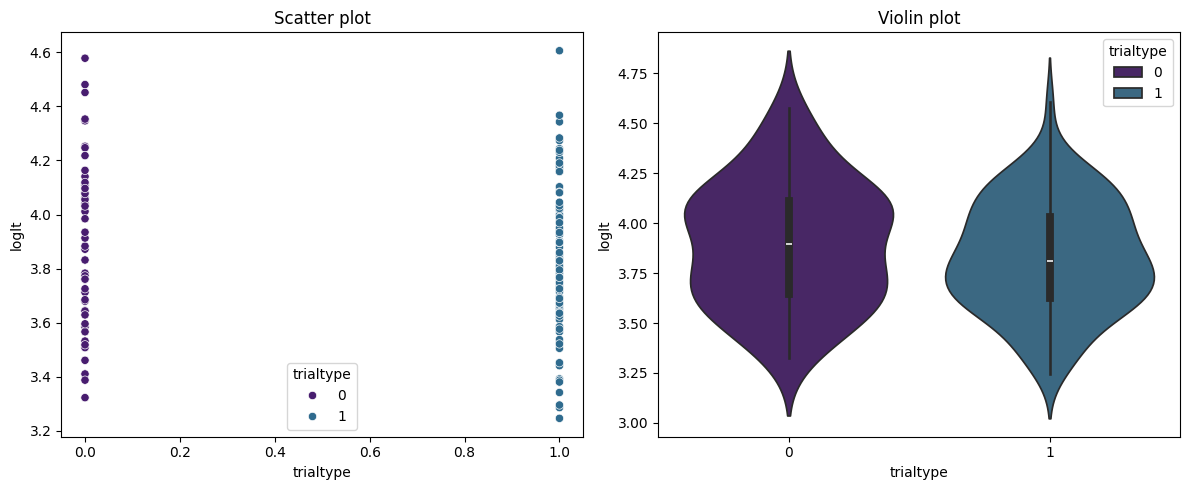

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot like geom_point()
sns.scatterplot(x='trialtype', y='loglt', hue='trialtype', data=data, ax=axes[0])
axes[0].set_title('Scatter plot')

# Violin plot like geom_violin()
sns.violinplot(x='trialtype', y='loglt', hue='trialtype', data=data, ax=axes[1], split=False)
axes[1].set_title('Violin plot')

plt.tight_layout()
plt.show()

Looking at the violin plot and boxplot, there might be a slight difference between the two trial types. There might also not be. We could also look at this on an individual level.

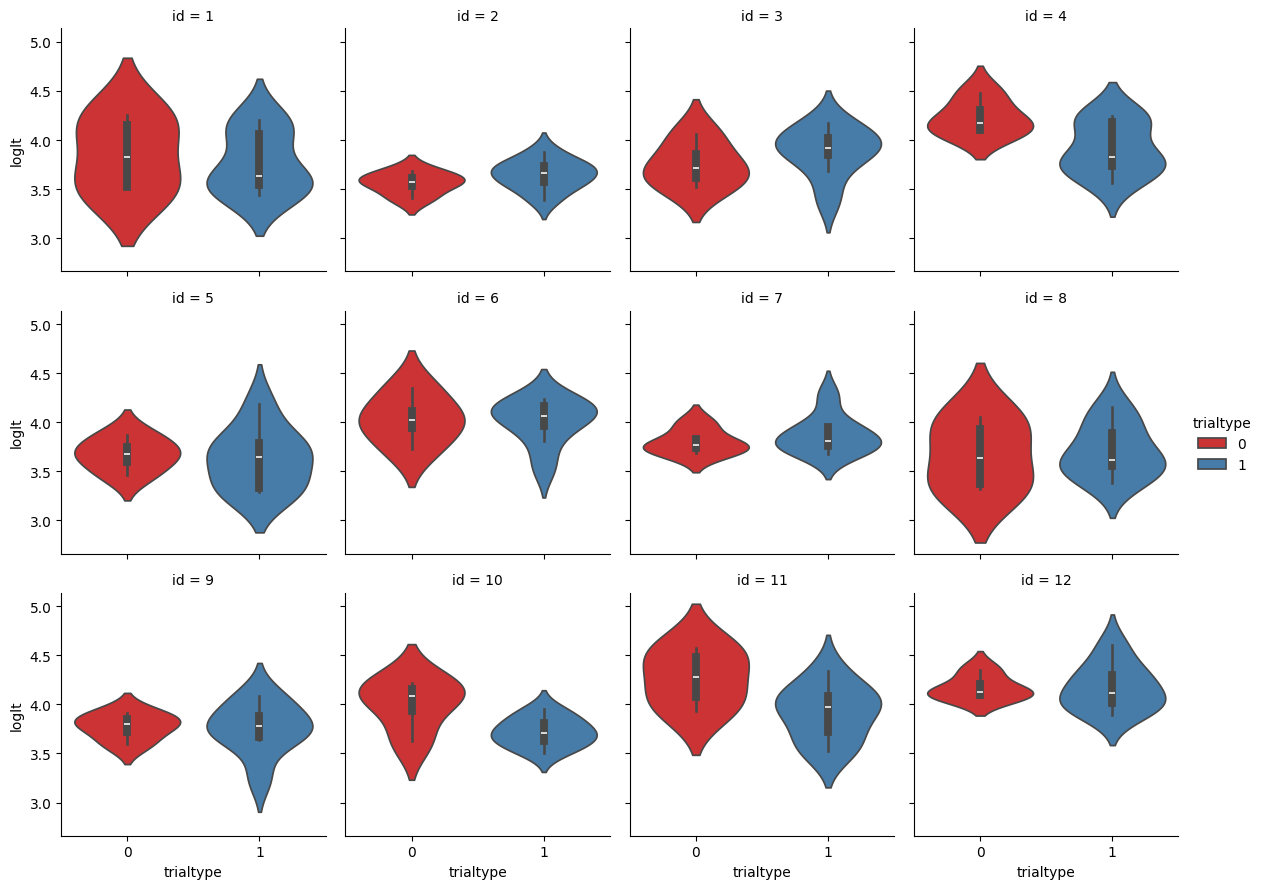

In [60]:
g = sns.FacetGrid(data, col="id", col_wrap=4, sharey=True)
g.map_dataframe(sns.violinplot, x='trialtype', y='loglt', hue='trialtype', dodge=False, palette='Set1')

g.add_legend(title='trialtype')

plt.show()

Now we are going to rely on the default priors in `bambi` and look how we can use posterior predictive checks to help us change our model. In the first model we are going to try and explain the log looking time by using trial number (time) and trial type.
At this point, we should include an autoregressive effect over time as infants might experience fatigue during the experiment and this might build up over time. AR models are not yet implemented in `bambi`, but can be coded directly [in PyMC](https://www.pymc.io/projects/examples/en/latest/time_series/AR.html). However, this would be outside the scope of this practical. Therefore we will continue without an AR effect for now.

Now, fit the model testing the effect of `trialnr` and `trialtype` on `loglt` using default priors.

In [67]:
# Exercise 4: Please try writing and running the code yourself before checking the correct solution below

Output()

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept     3.903  0.065   3.780    4.022      0.003    0.002     652.0   
sigma         0.292  0.017   0.256    0.321      0.000    0.000    1470.0   
trialnr      -0.000  0.007  -0.014    0.012      0.000    0.000     792.0   
trialtype[1] -0.068  0.052  -0.163    0.029      0.002    0.001    1142.0   

              ess_tail  r_hat  
Intercept        836.0    1.0  
sigma           1392.0    1.0  
trialnr          914.0    1.0  
trialtype[1]    1235.0    1.0

<details><summary>Click here for the solution</summary>

```python
model = bmb.Model("loglt ~ trialnr + trialtype", data=data,
                  center_predictors=False)
fit = model.fit(seed=SEED)

az.summary(fit)

```

</details>

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'trialnr'}>,
        <Axes: title={'center': 'trialnr'}>],
       [<Axes: title={'center': 'trialtype'}>,
        <Axes: title={'center': 'trialtype'}>]], dtype=object)

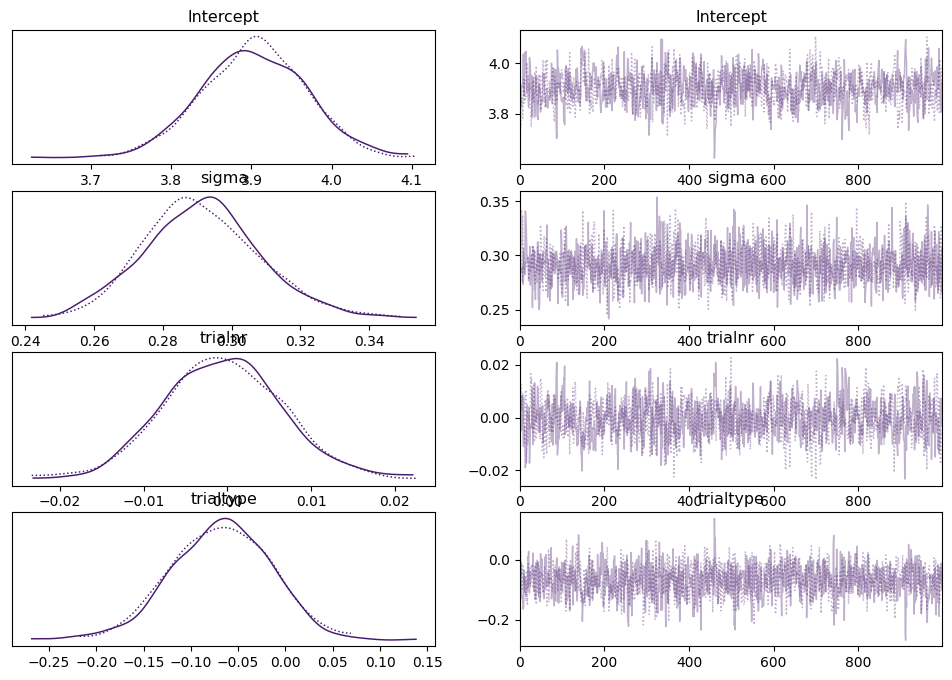

In [68]:
az.plot_trace(fit)

Fitting seems to have gone well. Nicely mixed chain plots, smooth densities, nice Rhat and Effective sample size. Let's look at the posterior predictives.

<Axes: xlabel='loglt'>

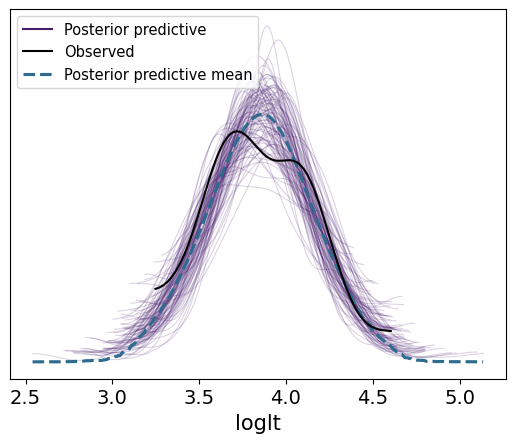

In [69]:
model.predict(fit, kind="response")
az.plot_ppc(fit, num_pp_samples=100)

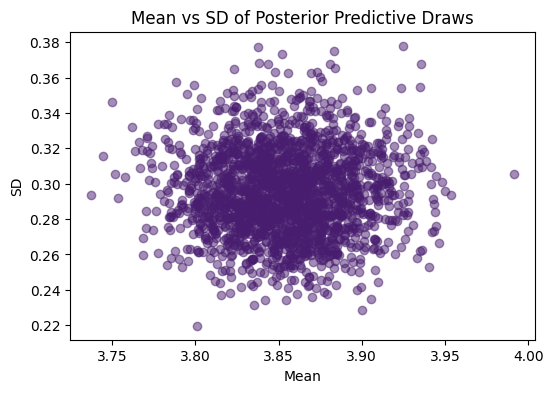

In [71]:
# Extract and stack the prior predictive samples
y_post = fit["posterior_predictive"].stack(sample=("chain", "draw"))

# Compute mean for each sample
means_per_draw_post = y_post.mean(dim="__obs__")

# Compute std for each sample
sds_per_draw_post = y_post.std(dim="__obs__")

plt.figure(figsize=(6, 4))
plt.scatter(means_per_draw_post["loglt"], sds_per_draw_post["loglt"], alpha=0.5)
plt.title("Mean vs SD of Posterior Predictive Draws")
plt.xlabel("Mean")
plt.ylabel("SD")
plt.show()

If we look at the posterior predictive plots that we used before, all seems quite well. But, we are looking at a very aggregated level. Perhaps we should zoom in a little bit. We can use the code below to look for each individual on each time point how the predictions look.

/usr/local/lib/python3.11/dist-packages/bambi/models.py:851: FutureWarning: 'mean' has been replaced by 'response_params' and is not going to work in the future
  warnings.warn(


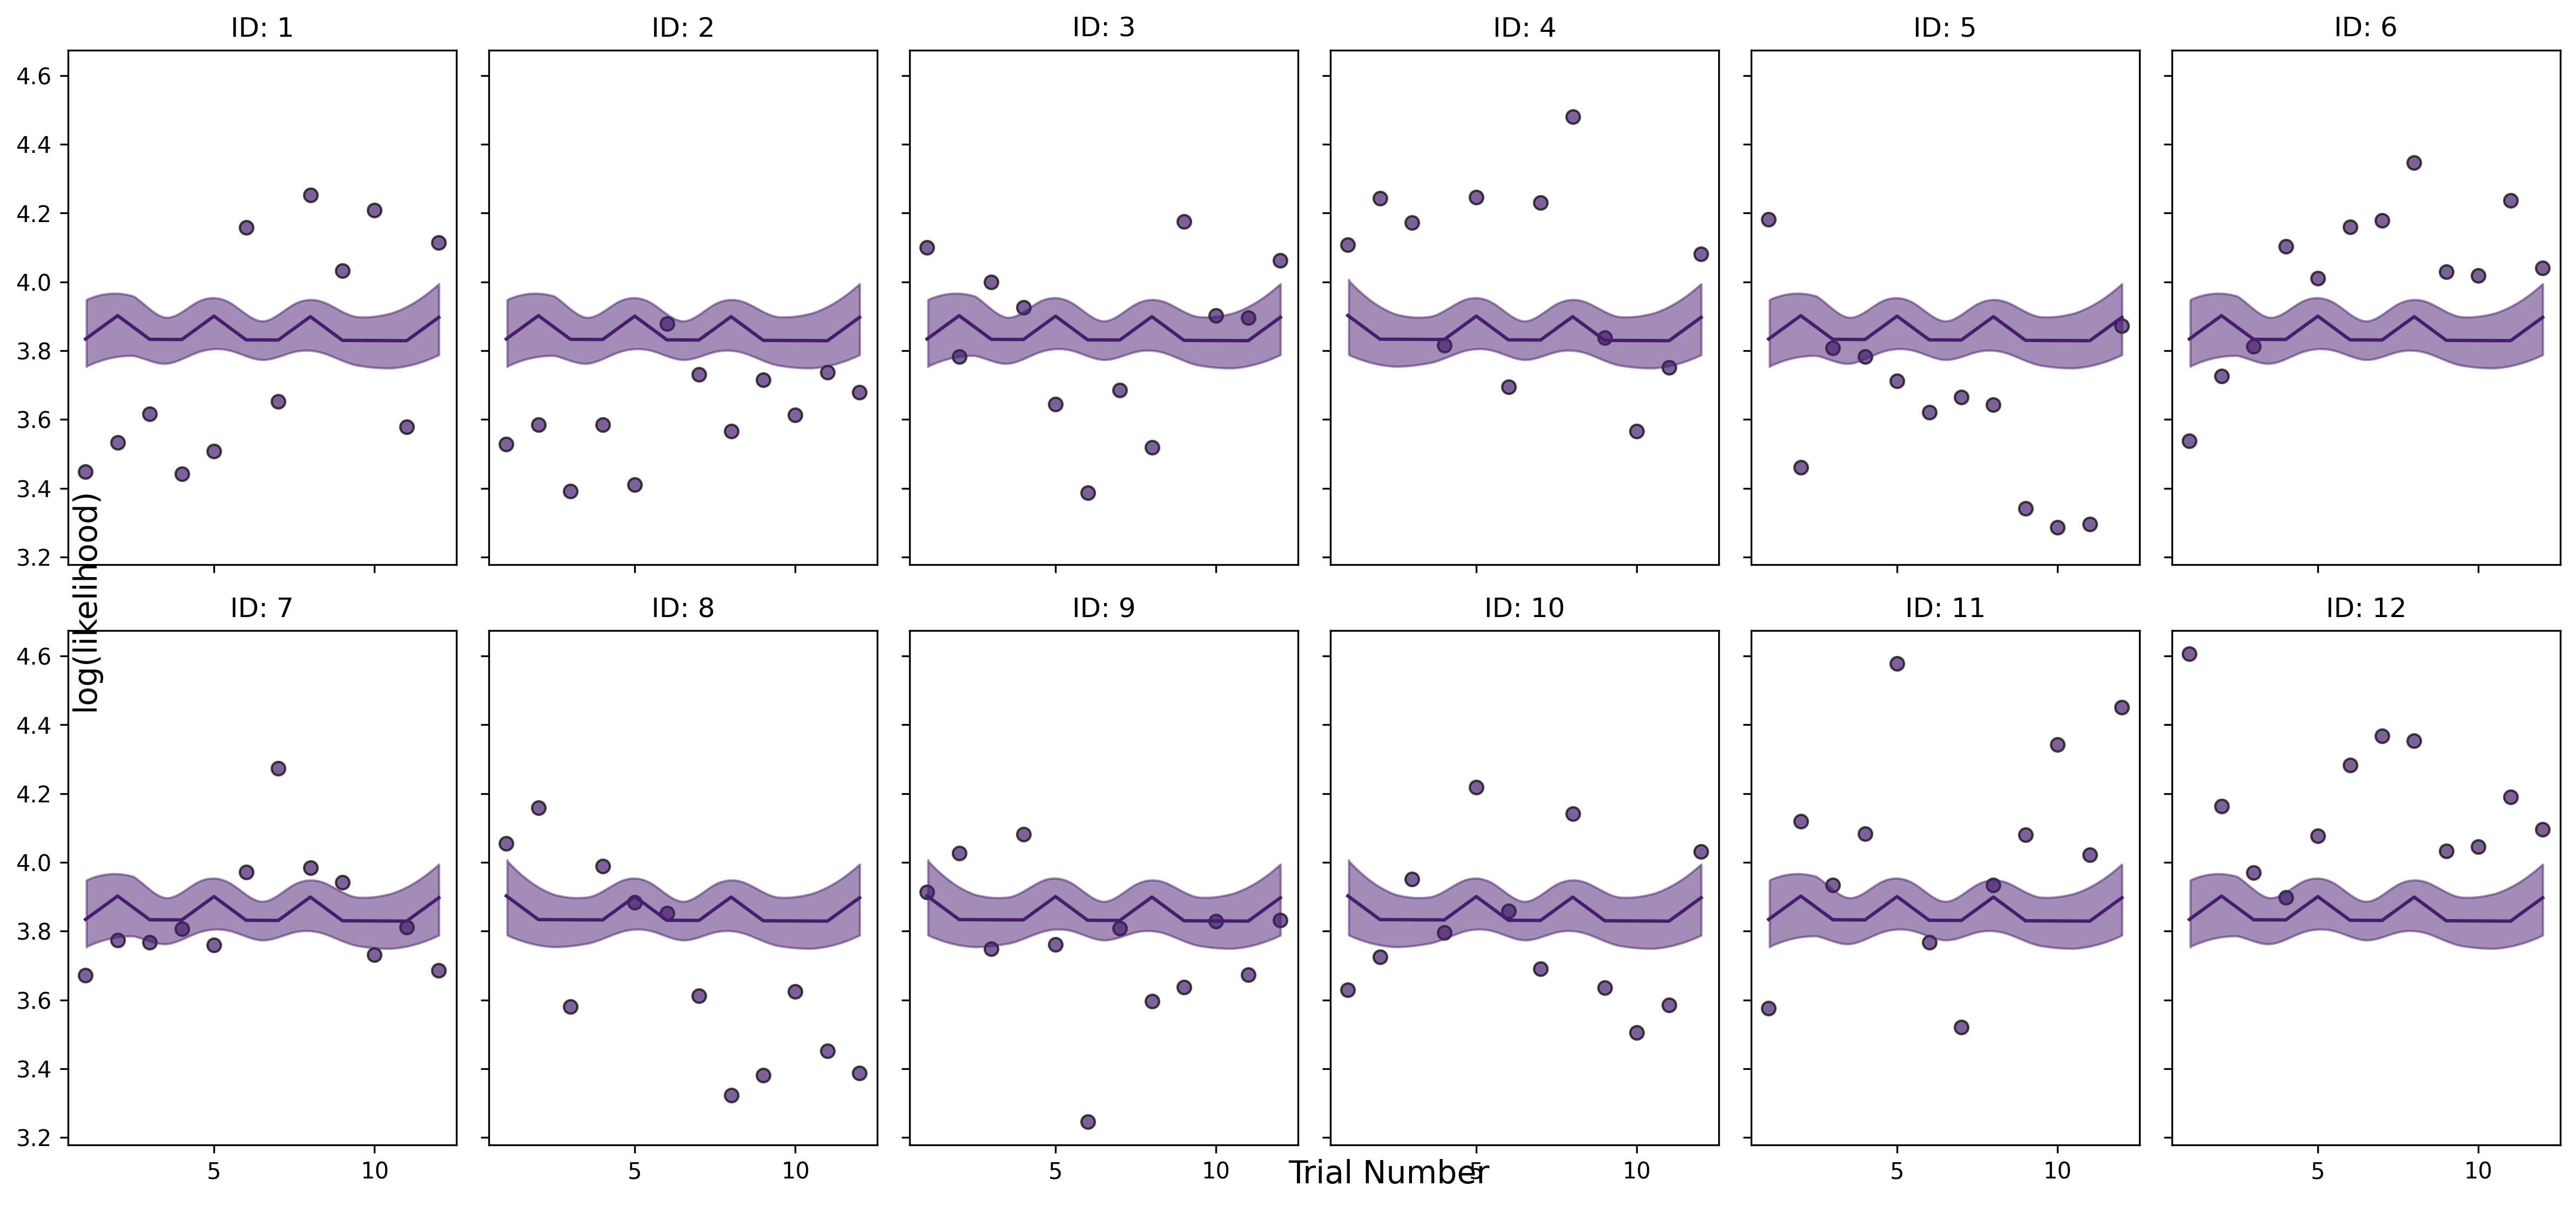

In [72]:
# Define plotting function (see https://bambinos.github.io/bambi/notebooks/radon_example.html)
def plot_data(data):
    subjects = data["id"].unique()
    fig, axes = plt.subplots(2, int(np.ceil(len(subjects) / 2)), figsize=(16, 7.5), sharey=True, sharex=True, dpi=300)
    fig.subplots_adjust(left=0.075, right=0.975, bottom=0.075, top=0.925, wspace=0.03)
    axes_flat = axes.ravel()

    for i, subject in enumerate(subjects):
        ax = axes_flat[i]
        idx = data.index[data["id"] == subject].tolist()
        x = data.loc[idx, "trialnr"].values
        y = data.loc[idx, "loglt"].values

        ax.scatter(x, y, color="C0", ec="black", alpha=0.7)
        ax.set_title(f"ID: {subject}", fontsize=12)
        ax.xaxis.set_ticks([0, 5, 10, 15, 20])

    fig.text(0.5, 0.02, "Trial Number", fontsize=14)
    fig.text(0.03, 0.5, "log(likelihood)", rotation=90, fontsize=14, va="center")
    return axes

# Predict posterior mean of response variable
posterior_predictive = model.predict(fit, kind="mean", inplace=False)
mu = az.extract(fit)["mu"].values  # posterior samples of the mean

# Plot the data
axes = plot_data(data)

# Overlay posterior mean and HDIs
for subject, ax in zip(data["id"].unique(), axes.ravel()):
    idx = data.index[data["id"] == subject].tolist()
    x = data.loc[idx, "trialnr"].values

    # Plot HDI
    az.plot_hdi(x, mu[idx].T[np.newaxis], color="C0", ax=ax)

    # Plot mean line
    ax.plot(x, mu[idx].mean(axis=1), color="C0")

plt.tight_layout()
plt.show()

This is great, we see the predictions for each individual at each time point. And what turns out? Our model is doing a terrible job! We are basically predicting the same thing for each time point of each individual with very very tiny shifts based on the trial type. In addition, we often do not even have enough uncertainty to capture most measurements. Not a useful model at all actually.

So what can we change? We didn't include any multilevel structure, whilst the data follows a multilevel structure, namely trials within individuals. Let's try a different model. Let us include a random effect for the intercept, the trial number and the trial type. This model is a bit different, we are for instance modelling the trial numbers as random effect. But, we are taking the hierarchical structure of the data more into account. Let's try.

In [73]:
# Exercise 5: Please try writing and running the code yourself before checking the correct solution below

Output()

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept     3.898  0.076   3.747    4.029      0.003    0.003     907.0   
trialnr      -0.000  0.009  -0.019    0.015      0.000    0.000    1108.0   
trialtype[1] -0.065  0.048  -0.155    0.024      0.001    0.001    1627.0   

              ess_tail  r_hat  
Intercept       1087.0    1.0  
trialnr         1096.0    1.0  
trialtype[1]    1115.0    1.0

<details><summary>Click here for the solution</summary>

```python
model_ml = bmb.Model(
    "loglt ~ trialnr + trialtype + (1 + trialnr + trialtype | id)",
    data=data,
    center_predictors=False
)

fit_ml = model_ml.fit(random_seed=SEED,
                      target_accept=0.95)

az.summary(fit_ml, var_names=["Intercept", "trialnr", "trialtype"])

```

</details>

Let's go through the same first checks.

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'trialnr'}>,
        <Axes: title={'center': 'trialnr'}>],
       [<Axes: title={'center': 'trialtype'}>,
        <Axes: title={'center': 'trialtype'}>]], dtype=object)

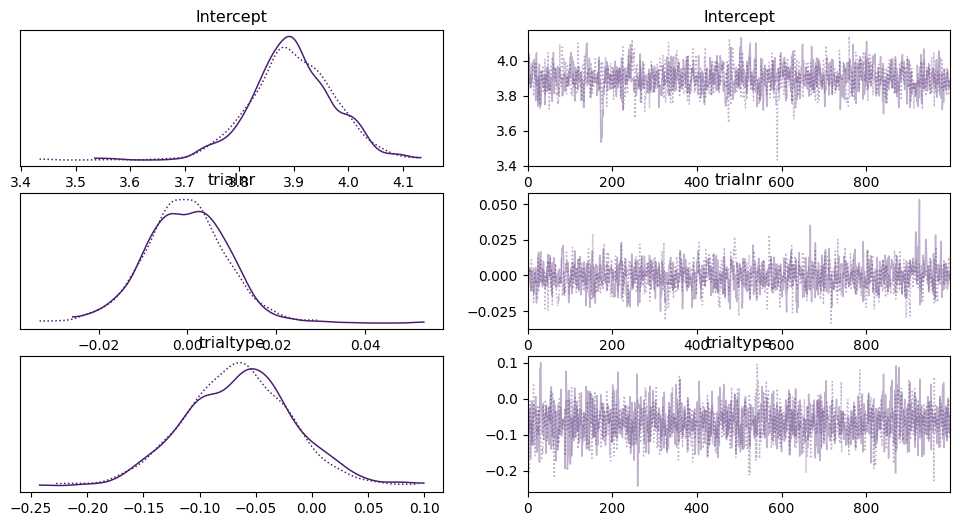

In [74]:
az.plot_trace(fit_ml, var_names=["Intercept", "trialnr", "trialtype"])

First signs look okay. Nicely mixed chain plots, smooth densities, nice Rhat and Effective sample size. Let's look at the posterior predictives of each trial type separately.

<Axes: xlabel='loglt'>

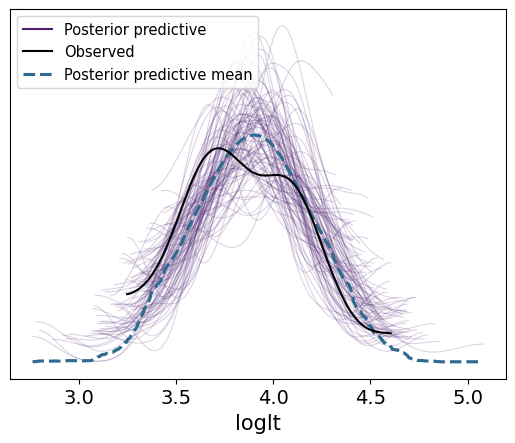

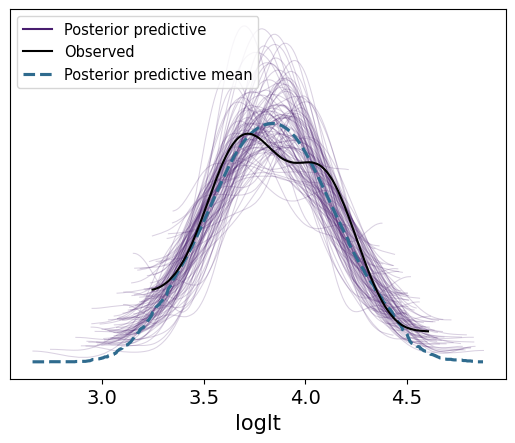

In [75]:
data_trial0 = data[data["trialtype"] == 0]
data_trial1 = data[data["trialtype"] == 1]

trial0_ppc = model_ml.predict(fit_ml, kind="response", data=data_trial0, inplace=False)
trial1_ppc = model_ml.predict(fit_ml, kind="response", data=data_trial1, inplace=False)

az.plot_ppc(trial0_ppc, num_pp_samples=100)
az.plot_ppc(trial1_ppc, num_pp_samples=100)

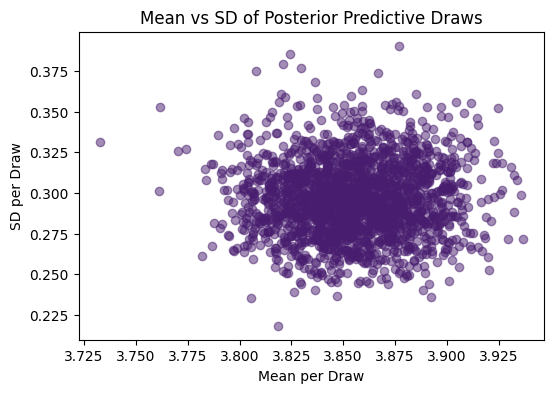

In [86]:
# Extract and stack the prior predictive samples
y_pred_ml = model_ml.predict(fit_ml, kind="response", data=data, inplace=False)
y_post = y_pred_ml["posterior_predictive"].stack(sample=("chain", "draw"))

# Compute mean for each sample
means_per_draw_post = y_post.mean(dim="__obs__")

# Compute std for each sample
sds_per_draw_post = y_post.std(dim="__obs__")

plt.figure(figsize=(6, 4))
plt.scatter(means_per_draw_post["loglt"], sds_per_draw_post["loglt"], alpha=0.5)
plt.title("Mean vs SD of Posterior Predictive Draws")
plt.xlabel("Mean per Draw")
plt.ylabel("SD per Draw")
plt.show()

Okay, if we split out per trial type our model doesn't fully capture all bumps but it's not to bad. The general mean and standard deviation are captured well. Now let's check where we encountered problems last time.

/usr/local/lib/python3.11/dist-packages/bambi/models.py:851: FutureWarning: 'mean' has been replaced by 'response_params' and is not going to work in the future
  warnings.warn(


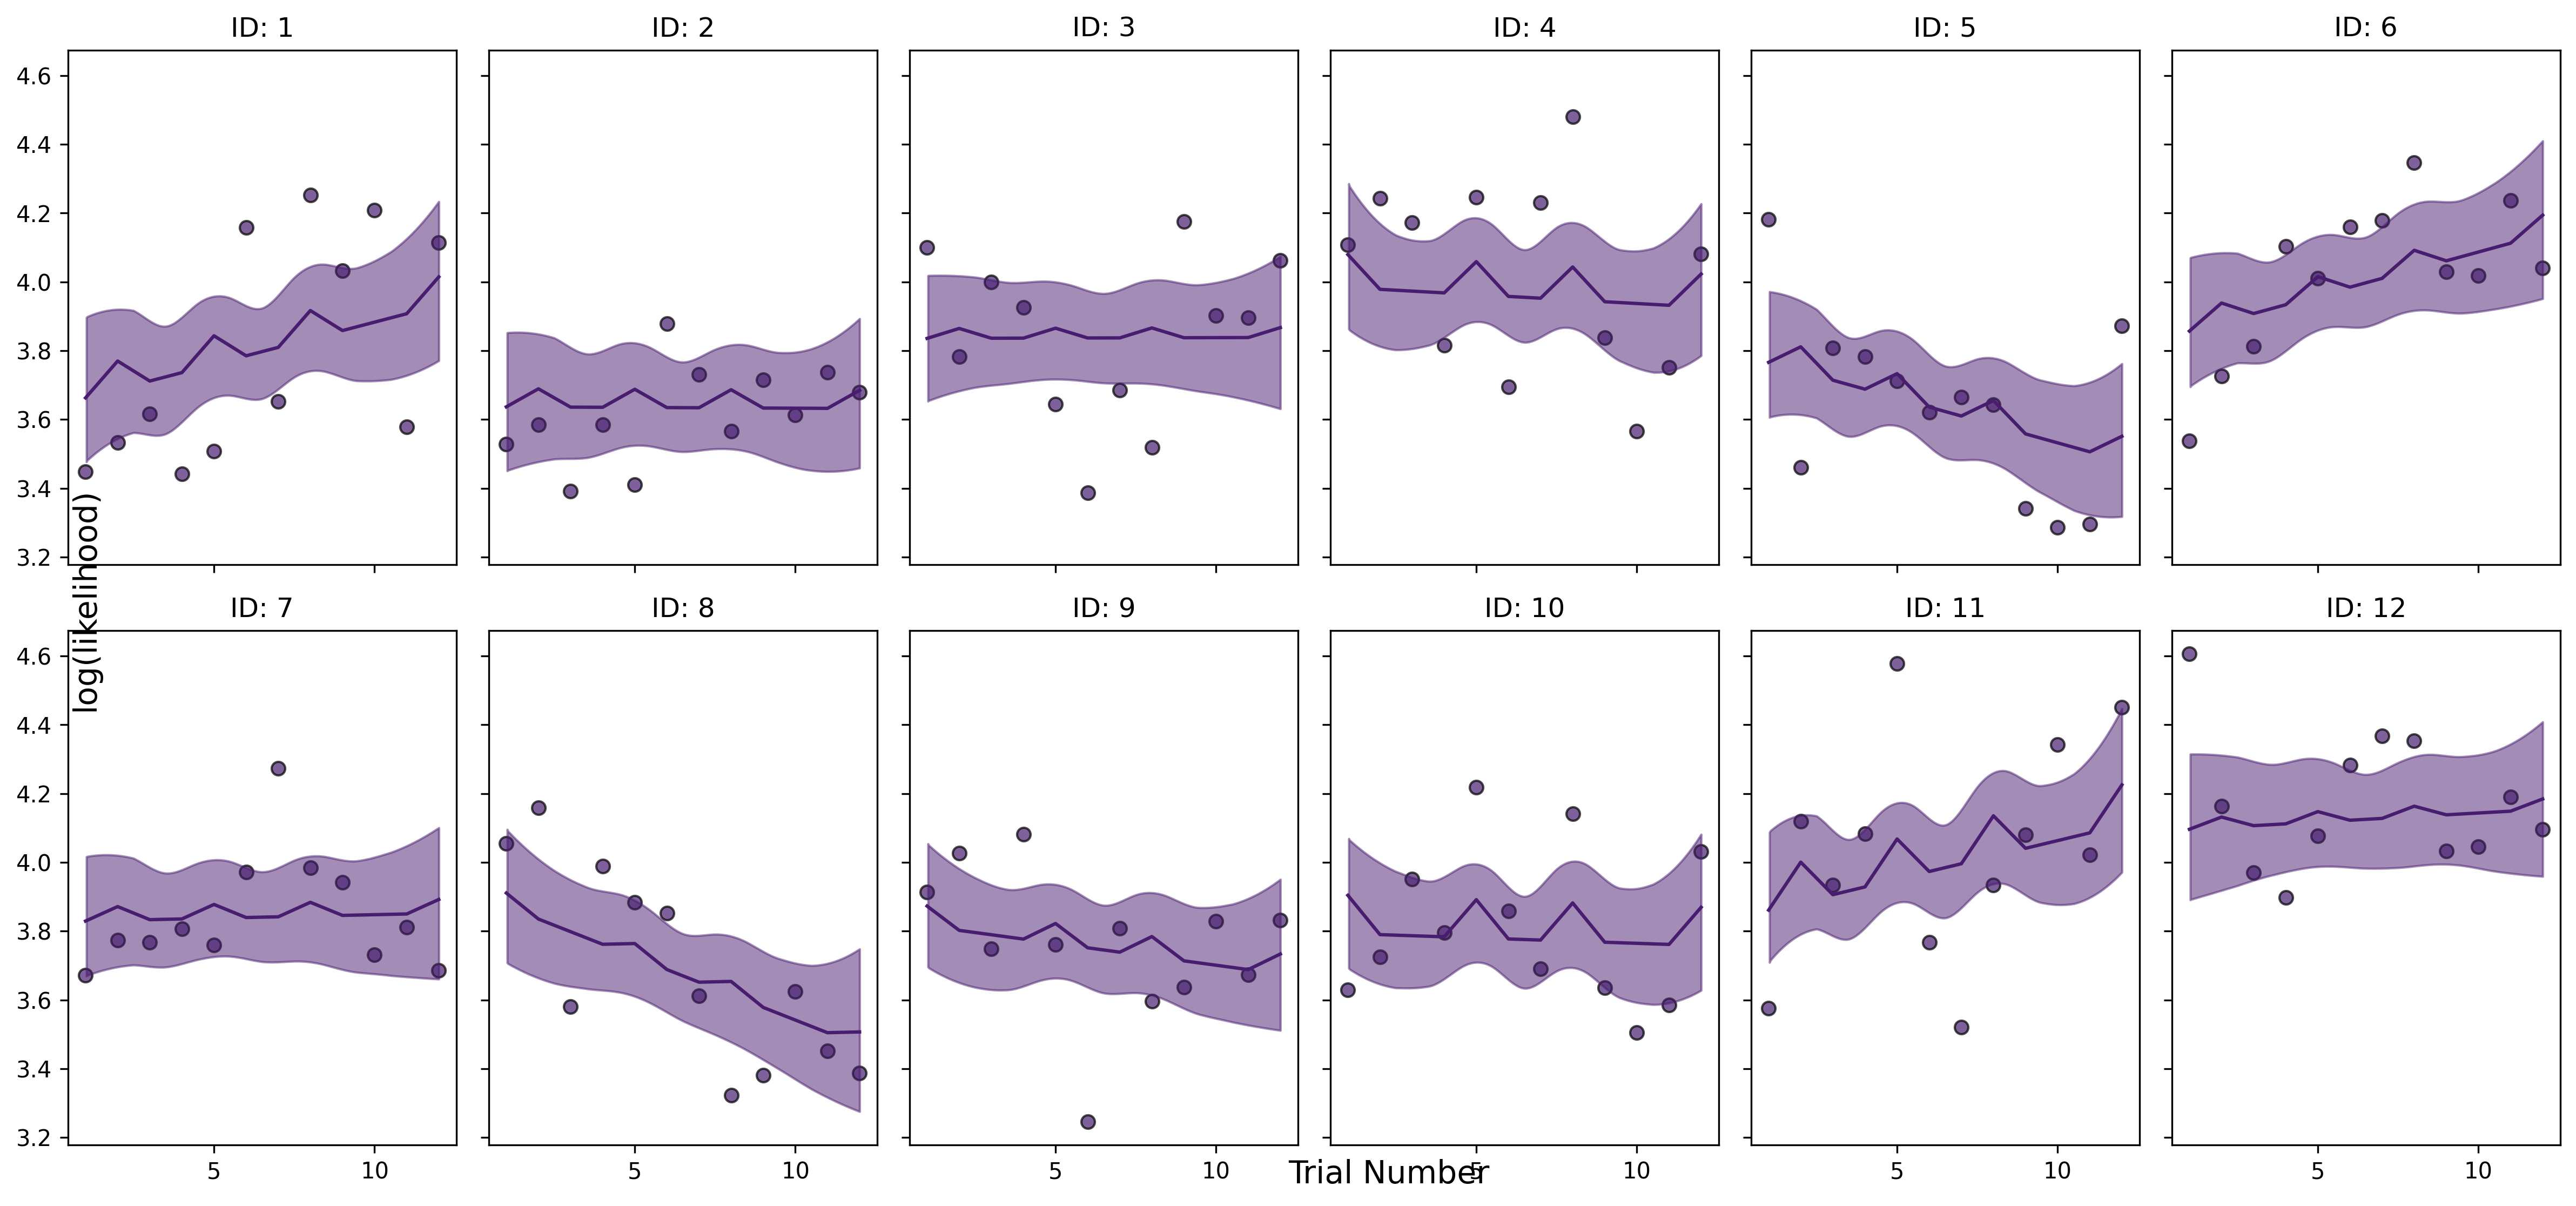

In [89]:
# Predict posterior mean of response variable
posterior_predictive = model_ml.predict(fit_ml, kind="mean", inplace=False)
mu = az.extract(posterior_predictive)["mu"].values  # posterior samples of the mean

# Plot the data
axes = plot_data(data)

# Overlay posterior mean and HDIs
for subject, ax in zip(data["id"].unique(), axes.ravel()):
    idx = data.index[data["id"] == subject].tolist()
    x = data.loc[idx, "trialnr"].values

    # Plot HDI
    az.plot_hdi(x, mu[idx].T[np.newaxis], color="C0", ax=ax)

    # Plot mean line
    ax.plot(x, mu[idx].mean(axis=1), color="C0")

plt.tight_layout()
plt.show()

We are now at least making differentiation between trial numbers, individuals and trends within individuals. See for instance the contrast between infant number 1 and infant number 8. We also seem to capture most data points. Therefore, we can conclude that we made an improvement in the model. A next step could be to include autoregressive effects for example and see if the model further improves.

We hope this example illustrates that we need to think at what level we want to check our model. Perhaps on an overall level we are doing fine, but if we are interested in data at a individual level or even at a trial level, we need to look how we are doing there. Posterior predictive checks can help to identify what is going on (e.g. we do not differentiate between individuals). We can adjust and hopefully improve our models based on that information.


## Conclusion

In this comprehensive tutorial, we've navigated through the realm of predictive checking in Bayesian estimation using the `bambi` package. We started by understanding the importance and roles of prior and posterior predictive checking in a Bayesian workflow. Using a simulated case of Dutch bike thefts, we grasped how prior predictive checking enables us to assess our model and its priors before applying them to real data. We also demonstrated how to adjust our model based on these checks. In the case of posterior predictive checking, we saw how it allows us to evaluate how well the model fits the observed data and how it performs against new data. In our case study, we applied posterior predictive checks on infants' speech discrimination data. Through this process, we were able to evaluate the validity of our model and improve it by incorporating a multilevel structure. As this tutorial comes to a close, we hope that the concepts, techniques, and code examples shared equip you to confidently apply predictive checking in your Bayesian analyses.


## Footnotes

<a name="cite_note-1"></a>1. [^](#cite_ref-1) See for instance: Schulz, S., Zondervan-Zwijnenburg, M., Nelemans, S. A., Veen, D., Oldehinkel, A. J., Branje, S., & Meeus, W. (2021). Systematically defined informative priors in Bayesian estimation: An empirical application on the transmission of internalizing symptoms through mother-adolescent interaction behavior. Frontiers in Psychology, 12, 620802. https://doi.org/10.3389/fpsyg.2021.620802

<a name="cite_note-2"></a>2. [^](#cite_ref-2) de Klerk, M., Veen, D., Wijnen, F., & de Bree, E. (2019). A step forward: Bayesian hierarchical modelling as a tool in assessment of individual discrimination performance. *Infant Behavior and Development*, 57, 101345.